In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline

In [7]:
df = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding="ISO-8859-1")

In [8]:
df.head()

,Rank,Song,Artist,Year,Lyrics,Source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0


Text(0.5,1,'Maximum Lyrics Count By Artist')

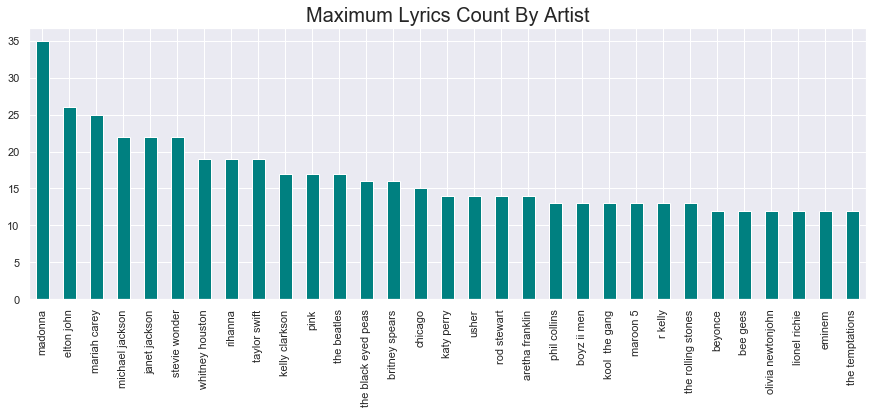

In [9]:
plt.figure(figsize=(15,5))
df['Artist'].value_counts()[:31].plot(kind='bar',color='teal')
plt.title("Maximum Lyrics Count By Artist",fontsize=20)

In [25]:
def topartist(year):
    df2 = df[df['Year'] == year]
    artist = df2['Artist'].value_counts()[:6]
    return artist

topartist(2013)

bruno mars         3
maroon 5           3
imagine dragons    3
miley cyrus        2
fun                2
hunter hayes       2
Name: Artist, dtype: int64

In [11]:
#plot top words from lyrics after cleaning
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamiezeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df.isnull().sum()

Rank        0
Song        0
Artist      0
Year        0
Lyrics    187
Source    187
dtype: int64

In [13]:
df.dropna(inplace=True)

**Remove Stopwords**

In [14]:
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [15]:
df['Lyrics'] = df['Lyrics'].apply(remove_stopwords)

**Stemming**

In [16]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [17]:
df['Lyrics'] = df['Lyrics'].apply(stemming)

In [26]:
lyrics = df['Lyrics'].str.split(expand=True).unstack().value_counts()
lyrics.head(10)

love    16832
im      14278
know    11796
dont    11588
like    11078
oh       9741
get      9226
babi     9186
got      8337
want     7272
dtype: int64

In [19]:
trace=[go.Bar(
        x=lyrics.index[:51],
        y=lyrics.values[:51], 
        marker= dict(colorscale='Viridis', color = lyrics.values[:51]),
        text='Word counts', 
        )]

layout = go.Layout(title='Top Words Distribution (After cleaning)', xaxis=dict(tickangle=-45))
fig = go.Figure(data=trace, layout=layout)
py.iplot(fig)


**As we can see, even plotting the top words can't still tell us the overall sentiments of the reviews. We are going to apply Latent Dirichlet Allocation model for topic labeling purpose**

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.9, min_df=2)
#cv = CountVectorizer(max_df=0.9, min_df=2, stopwords = 'english') if not apply stopwords function above
dtm = cv.fit_transform(df['Lyrics'])
dtm

<4913x12851 sparse matrix of type '<class 'numpy.int64'>'
	with 354413 stored elements in Compressed Sparse Row format>

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=7, random_state=42)

In [30]:
LDA.fit(dtm)
single_topic = LDA.components_[0]
top_twenty_words = single_topic.argsort()[-20:]
for index in top_twenty_words:
    print(cv.get_feature_names()[index])

make
man
see
shit
put
money
caus
uh
boy
nigga
dont
em
girl
back
know
aint
get
got
im
like


In [23]:
for i, topic in enumerate(LDA.components_):
    print(f'The top 20 words for topic #{i}')
    print([cv.get_feature_names()[index] for index in topic.argsort()[-20:]])
    print('\n')

The top 20 words for topic #0
['make', 'man', 'see', 'shit', 'put', 'money', 'caus', 'uh', 'boy', 'nigga', 'dont', 'em', 'girl', 'back', 'know', 'aint', 'get', 'got', 'im', 'like']


The top 20 words for topic #1
['get', 'got', 'give', 'good', 'take', 'know', 'right', 'see', 'babi', 'tonight', 'oh', 'littl', 'like', 'gonna', 'shake', 'let', 'im', 'come', 'na', 'go']


The top 20 words for topic #2
['let', 'say', 'make', 'yeah', 'need', 'caus', 'la', 'got', 'like', 'cant', 'gonna', 'want', 'girl', 'your', 'know', 'im', 'dont', 'love', 'babi', 'oh']


The top 20 words for topic #3
['want', 'bodi', 'parti', 'ya', 'roll', 'babi', 'oh', 'beat', 'keep', 'got', 'go', 'hey', 'night', 'come', 'dont', 'rock', 'danc', 'da', 'let', 'get']


The top 20 words for topic #4
['ever', 'take', 'said', 'back', 'fire', 'got', 'red', 'music', 'boy', 'live', 'hand', 'bodi', 'like', 'girl', 'danc', 'come', 'night', 'shes', 'want', 'yeah']


The top 20 words for topic #5
['like', 'say', 'day', 'life', 'your', 

**Creat a new column and put the labels in**

In [31]:
top_result = LDA.transform(dtm)

In [32]:
df['Topic'] = top_result.argmax(axis=1)
df.head(15)

,Rank,Song,Artist,Year,Lyrics,Source,Topic
0,1,wooly bully,sam the sham and the pharaohs,1965,sam sham miscellan wooli bulli wooli bulli sam...,3.0,1
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch know love cant help love...,1.0,2
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0,0
3,4,you were on my mind,we five,1965,woke morn mind mind got troubl whoaoh got worr...,1.0,0
4,5,youve lost that lovin feelin,the righteous brothers,1965,never close eye anymor kiss lip there tender l...,1.0,2
5,6,downtown,petula clark,1965,your alon life make lone alway go downtown you...,1.0,5
6,7,help,the beatles,1965,help need somebodi help anybodi help know need...,3.0,5
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewi everi time see lookin way babi babi...,5.0,2
8,9,crying in the chapel,elvis presley,1965,saw cri chapel tear shed tear joy know mean co...,1.0,5
9,10,my girl,the temptations,1965,ive got sunshin cloudi day cold outsid ive got...,3.0,2
